In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import sys
from collections import defaultdict
from pathlib import Path
from typing import Dict, List, Literal, Optional, Tuple, Union
import plotly.express as px
import scipy
import camelot
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib.axes import Axes as Axes
from pypdf import PdfReader

notebook_path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
project_dir = notebook_path.parent.parent
sys.path.append(str(project_dir))
import src.utils.custom_log as custom_log
from src.utils.Csv import Csv
from src.utils.iso18571 import ISO18571
from src.utils.iso18571_openvt import ISO18571 as ISO18571Openvt
from src.utils.set_rcparams import set_rcparams
from src.utils.UnifySignal import UnifySignal

os.chdir(project_dir)
LOG = custom_log.init_logger(__name__)

custom_log.set_level(custom_log.LEVELS.INFO)
READ_NEW = False
STORE_NEW = False
LOG.info("Log initialized - Read New %s", READ_NEW)

set_rcparams()

2024-05-29 09:56:31,300 MainProcess - MainThread INFO Log initialized - Read New False || 2501840975.py


In [2]:
B_PATH = Path("data") / "iso18571"
if B_PATH.is_dir():
    LOG.info("Path %s found", B_PATH)
else:
    LOG.critical("Path %s not found", B_PATH)

2024-05-29 09:56:31,357 MainProcess - MainThread INFO Path data/iso18571 found || 1260868679.py


# Get Data

In [3]:
def get_data_from_pdf() -> Dict[str, pd.DataFrame]:
    pages = "22,25,28,31,34,37,40,43,46,49,52,55,58,61"
    pdf_path = B_PATH / "iso_1871_2014.pdf"
    log_lvl = LOG.level
    custom_log.set_level(custom_log.LEVELS.INFO) # DEBUG level is too verbose here


    reader = PdfReader(pdf_path)
    test_sets = []

    for page in (int(x) for x in pages.split(",")):
        for line in reader.pages[page - 1].extract_text().split("\n"):

            if re.search("A\.\d\.\d.+", line):

                LOG.info("Found %s", line)
                test_sets.append(line[6:])


    tables = camelot.read_pdf(
        str(pdf_path),
        pages=pages,
        flavor="stream",
        row_tol=9,

        column_tol=10,
        strip_text="\n",
        flag_size=True,
    )
    custom_log.set_level(log_lvl)
    reference_scores: Dict[str, pd.DataFrame]= {}

    for t_name, table in zip(test_sets, tables):
        db = pd.DataFrame(
            table.df.iloc[3:, 1:].values,
            index=[x[1:].split(">")[-1].strip(",") for x in table.df.iloc[3:, 0]],
            columns=[x.split("(")[0].strip() for x in table.df.iloc[0, 1:]],
        )

        db.drop(columns=[")"], inplace=True)
        db.replace({",": "."}, regex=True, inplace=True)
        db.rename(index={"lope score": "Slope score"}, inplace=True)

        reference_scores[t_name] = db.astype(float, errors="ignore")

        f_dir = B_PATH / "reference_ratings"
        f_dir.mkdir(exist_ok=True)
        f_path = f_dir / f"{t_name}.csv"
        LOG.info("Writing %s", f_path)
        reference_scores[t_name].to_csv(f_path)
        

    return reference_scores


def read_from_csv() -> Dict[str, pd.DataFrame]:
    reference_scores = {}
    for csv in (B_PATH / "reference_ratings").glob("*.csv"):
        LOG.info("Reading %s", csv)
        reference_scores[csv.stem] = pd.read_csv(csv, index_col=0)
    return reference_scores

REFERENCE_SCORES: Dict[str, pd.DataFrame] = get_data_from_pdf() if READ_NEW else read_from_csv()
# correct values from ISO/DTS 18571.2:2024
REFERENCE_SCORES["Moment 2"].loc["Phase score", "CAE1"] = 0.497
REFERENCE_SCORES

2024-05-29 09:56:31,395 MainProcess - MainThread INFO Reading data/iso18571/reference_ratings/Moment 3.csv || 968435039.py
2024-05-29 09:56:31,401 MainProcess - MainThread INFO Reading data/iso18571/reference_ratings/Displacement 2.csv || 968435039.py
2024-05-29 09:56:31,405 MainProcess - MainThread INFO Reading data/iso18571/reference_ratings/Force 2.csv || 968435039.py
2024-05-29 09:56:31,408 MainProcess - MainThread INFO Reading data/iso18571/reference_ratings/Acceleration 1.csv || 968435039.py
2024-05-29 09:56:31,411 MainProcess - MainThread INFO Reading data/iso18571/reference_ratings/Force 1.csv || 968435039.py
2024-05-29 09:56:31,414 MainProcess - MainThread INFO Reading data/iso18571/reference_ratings/Acceleration 4.csv || 968435039.py
2024-05-29 09:56:31,417 MainProcess - MainThread INFO Reading data/iso18571/reference_ratings/Displacement 1.csv || 968435039.py
2024-05-29 09:56:31,419 MainProcess - MainThread INFO Reading data/iso18571/reference_ratings/Moment 1.csv || 9684350

{'Moment 3':                   CAE1   CAE2   CAE3
 Overall rating   0.654  0.655  0.665
 Corridor score   0.539  0.538  0.556
 Phase score      0.677  0.696  0.962
 Magnitude score  0.840  0.798  0.735
 Slope score      0.674  0.707  0.515,
 'Displacement 2':                   CAE1   CAE2   CAE3
 Overall rating   0.647  0.859  0.829
 Corridor score   0.470  0.807  0.791
 Phase score      0.809  0.929  0.844
 Magnitude score  0.689  0.943  0.956
 Slope score      0.797  0.811  0.763,
 'Force 2':                   CAE1   CAE2   CAE3
 Overall rating   0.261  0.569  0.632
 Corridor score   0.375  0.428  0.521
 Phase score      0.500  0.357  0.857
 Magnitude score  0.000  0.850  0.658
 Slope score      0.055  0.782  0.602,
 'Acceleration 1':                   CAE1   CAE2   CAE3
 Overall rating   0.910  0.877  0.906
 Corridor score   0.956  0.898  0.922
 Phase score      0.936  0.904  0.968
 Magnitude score  0.952  0.964  0.972
 Slope score      0.751  0.721  0.745,
 'Force 1':              

2024-05-29 09:56:31,496 MainProcess - MainThread INFO Reading data/iso18571/annex_c_1_1__ac1__cae3.csv || 3423863514.py
2024-05-29 09:56:31,507 MainProcess - MainThread INFO Reading data/iso18571/annex_c_4_1__fo1__cae1.csv || 3423863514.py
2024-05-29 09:56:31,514 MainProcess - MainThread INFO Reading data/iso18571/annex_c_5_2__mo2__cae3.csv || 3423863514.py
2024-05-29 09:56:31,522 MainProcess - MainThread INFO Reading data/iso18571/annex_c_2_1__an1__cae1.csv || 3423863514.py
2024-05-29 09:56:31,533 MainProcess - MainThread INFO Reading data/iso18571/annex_c_2_2__an2__cae1.csv || 3423863514.py
2024-05-29 09:56:31,547 MainProcess - MainThread INFO Reading data/iso18571/annex_c_2_1__an1__cae2.csv || 3423863514.py
2024-05-29 09:56:31,561 MainProcess - MainThread INFO Reading data/iso18571/annex_c_4_2__fo2__cae1.csv || 3423863514.py
2024-05-29 09:56:31,567 MainProcess - MainThread INFO Reading data/iso18571/annex_c_5_1__mo1__cae1.csv || 3423863514.py
2024-05-29 09:56:31,573 MainProcess - Ma

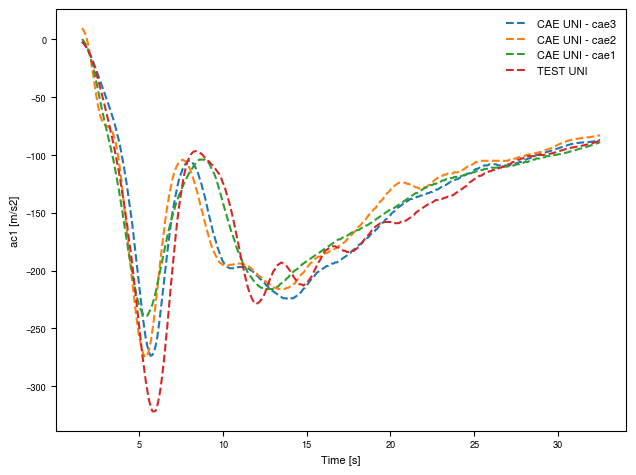

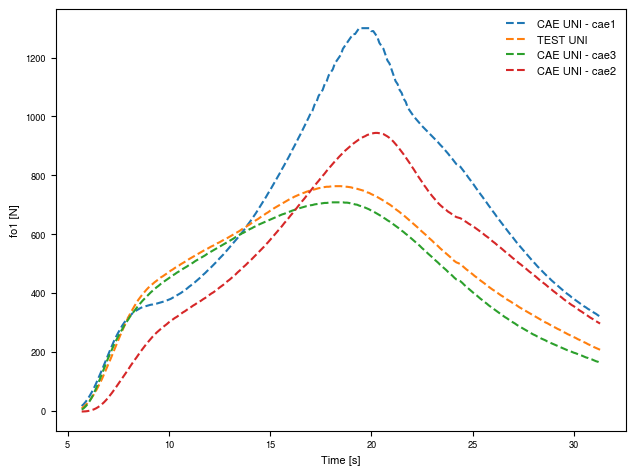

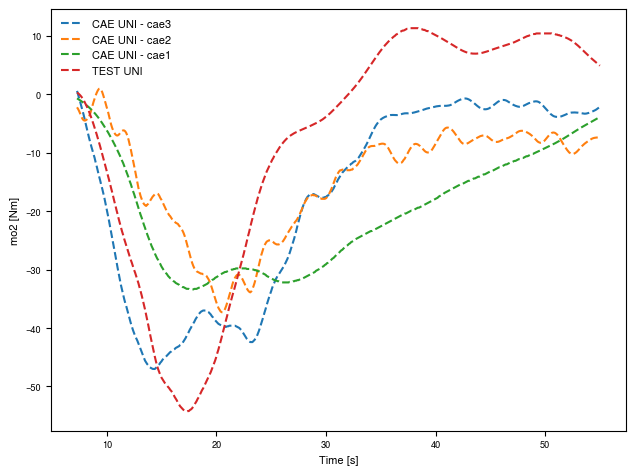

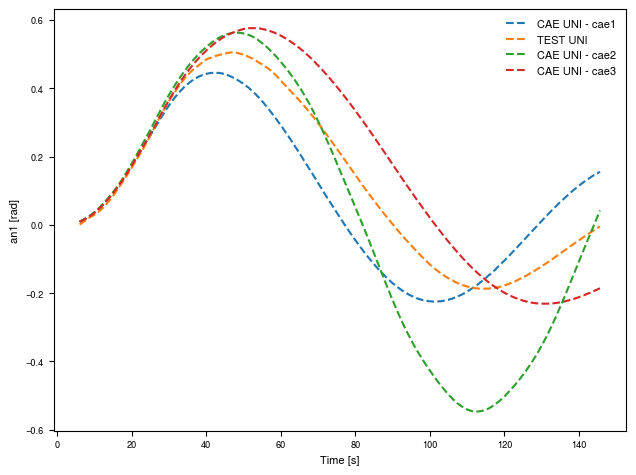

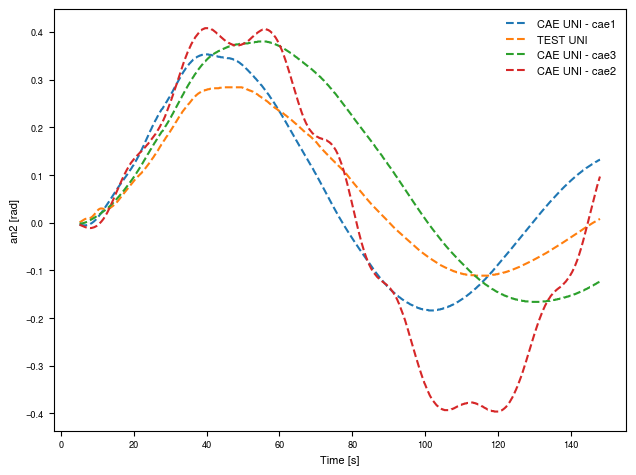

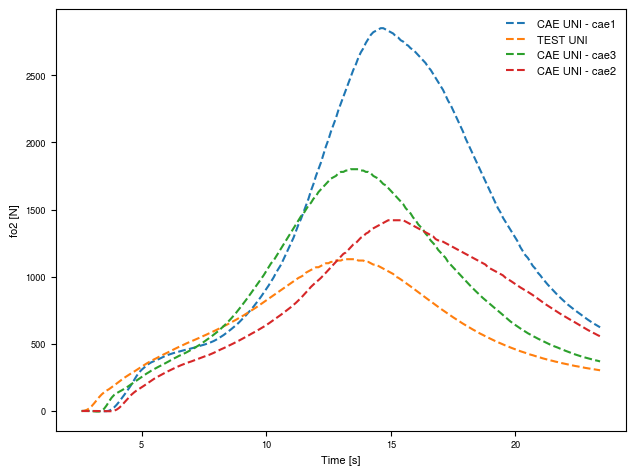

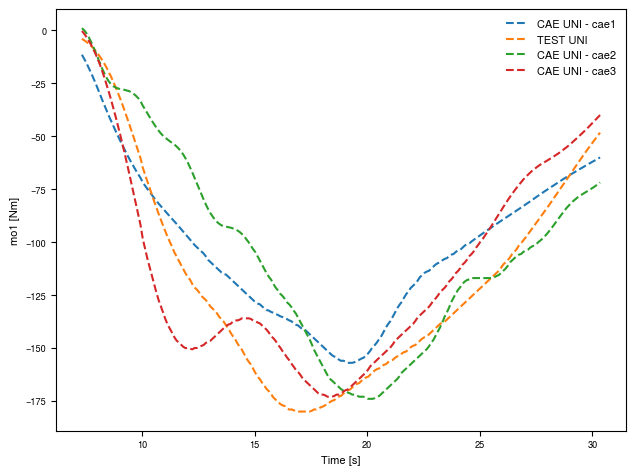

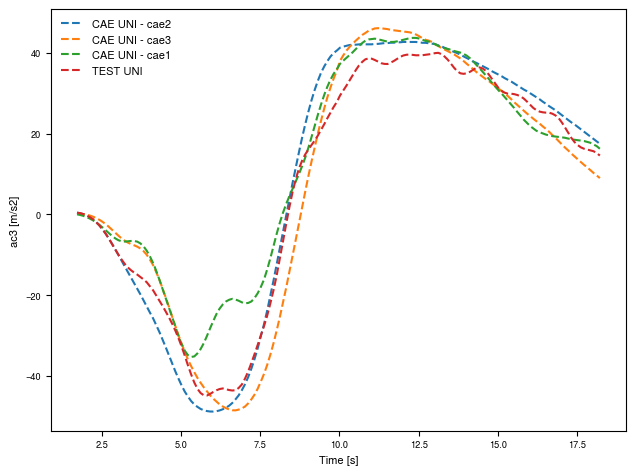

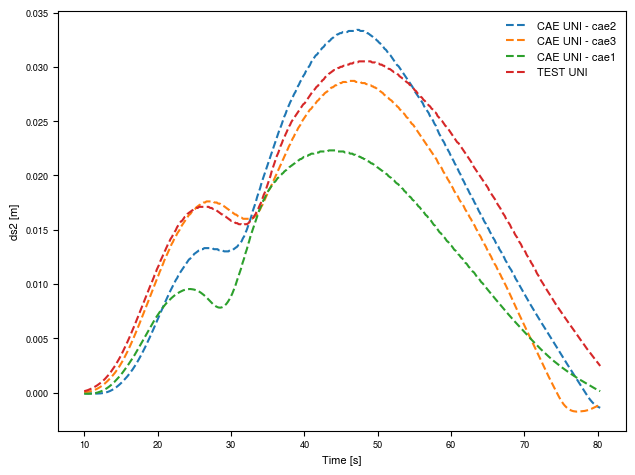

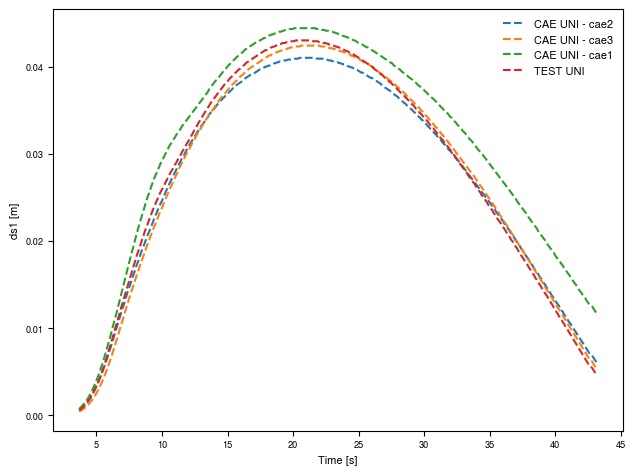

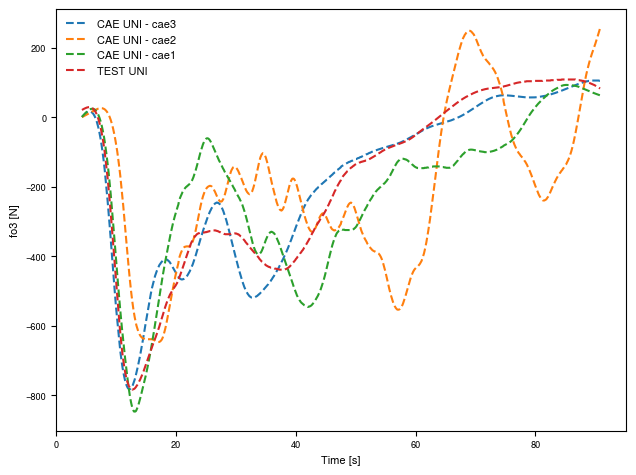

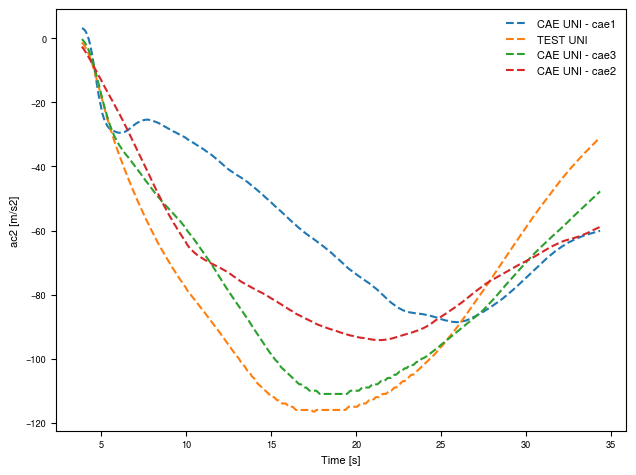

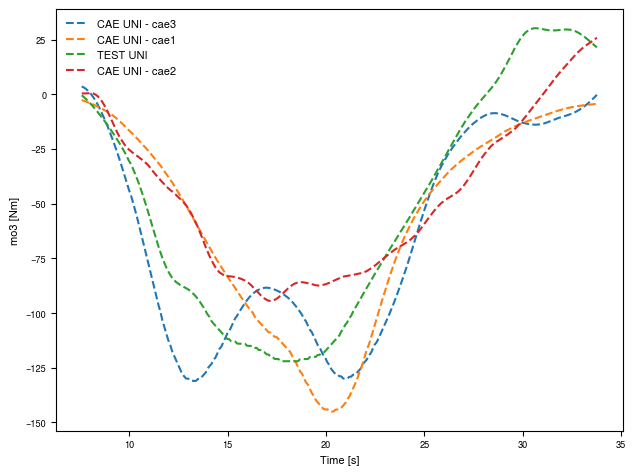

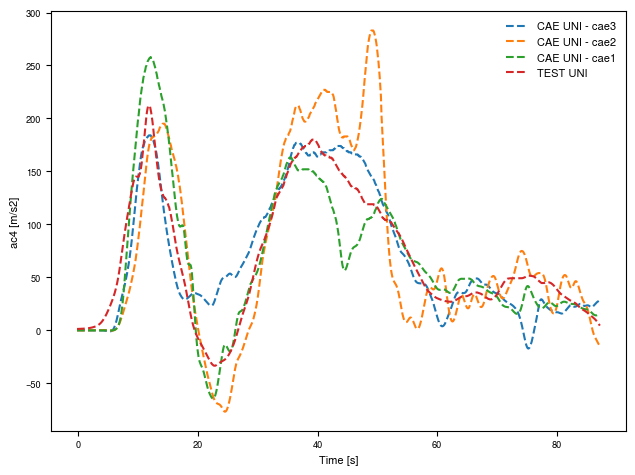

In [4]:
def get_channels() -> Dict[str, Dict[str, Dict[str, Union[dict, pd.DataFrame]]]]:
    data = defaultdict(dict)
    data_raw = defaultdict(dict)
    for csv in B_PATH.glob("annex*.csv"):
        LOG.info("Reading %s", csv)
        parts = csv.stem.split("__")
        cae = parts[-1]
        signal = parts[-2]
        db = pd.read_csv(csv, sep=";", usecols=[1, 2, 3])
        units = db.loc[0].to_dict()
        values = db.loc[1:].dropna().copy().astype(float)
        values.rename(columns={c: c[:-1] for c in values.columns if c.startswith("CAE")}, inplace=True)
        values.set_index("Time", inplace=True)
        cnt = values.shape[0]
        values = values.loc[~values.index.duplicated(keep='first')].copy()
        if cnt > values.shape[0]:
            LOG.warning("CSV %s countain %d doublets", csv.stem, cnt - values.shape[0])
        idx = values.index.copy()
        values.sort_index(inplace=True)
        if not all(idx == values.index):
            LOG.warning("CSV %s with not ordered index", csv.stem)
        values.index *= 1000
        data_raw[signal][cae] = values
        unifier = UnifySignal(target_tend_ms=values.index.max(), target_sampling_rate_ms=0.1, target_tstart_ms=values.index.min())
        values = unifier.unify(values)

        data[signal][cae] = {"Units": units, "Values": values.iloc[:-1].copy()}

    # plot
    for signal in data.keys():
        fig, ax = plt.subplots()
        for cae in data[signal].keys():
            #ax.plot(data_raw[signal][cae].index, data_raw[signal][cae]["CAE"], label=f"CAE RAW - {cae}")
            ax.plot(data[signal][cae]["Values"].index, data[signal][cae]["Values"]["CAE"], label=f"CAE UNI - {cae}", ls="--")
            if cae == "cae1":
                #ax.plot(data_raw[signal][cae].index, data_raw[signal][cae]["Test"], label="TEST RAW")
                ax.plot(data[signal][cae]["Values"].index, data[signal][cae]["Values"]["Test"], label="TEST UNI", ls="--")
        ax.legend()

        ax.set_ylabel(f"{signal} {data[signal][cae]['Units']['Test']}")
        ax.set_xlabel(f"Time {data[signal][cae]['Units']['Time']}")
        


    return dict(data)


CHANNEL_DATA: Dict[str, Dict[str, Dict[str, Union[dict, pd.DataFrame]]]] = get_channels()

In [5]:
def check_sampling_rates():
    fig, ax = None, None
    for signal in CHANNEL_DATA.keys():
        for cae in CHANNEL_DATA[signal].keys():
            LOG.info("Checking %s %s", signal, cae)
            values = CHANNEL_DATA[signal][cae]["Values"]
            diffs = np.diff(values.index)
            if not np.allclose(diffs, diffs[0], atol=3e-5):
                if fig is None:
                    fig, ax = plt.subplots()
                ax.plot(diffs, label=f"{signal} {cae}")
                LOG.error("Diffs not equal %s %s: min %s, max %s (delta: %s)", signal, cae, diffs.min(), diffs.max(), diffs.max()-diffs.min())
            else:
                LOG.info("Diffs equal %s %s: %s %s", signal, cae, diffs[0], CHANNEL_DATA[signal][cae]["Units"]["Time"])
    if fig is not None:
        ax.legend()
        ax.grid()

check_sampling_rates()

2024-05-29 09:56:34,915 MainProcess - MainThread INFO Checking ac1 cae3 || 4281548013.py
2024-05-29 09:56:34,918 MainProcess - MainThread INFO Diffs equal ac1 cae3: 0.10000000000000009 [s] || 4281548013.py
2024-05-29 09:56:34,920 MainProcess - MainThread INFO Checking ac1 cae2 || 4281548013.py
2024-05-29 09:56:34,921 MainProcess - MainThread INFO Diffs equal ac1 cae2: 0.10000000000000009 [s] || 4281548013.py
2024-05-29 09:56:34,922 MainProcess - MainThread INFO Checking ac1 cae1 || 4281548013.py
2024-05-29 09:56:34,923 MainProcess - MainThread INFO Diffs equal ac1 cae1: 0.10000000000000009 [s] || 4281548013.py
2024-05-29 09:56:34,923 MainProcess - MainThread INFO Checking fo1 cae1 || 4281548013.py
2024-05-29 09:56:34,924 MainProcess - MainThread INFO Diffs equal fo1 cae1: 0.09999999999999964 [s] || 4281548013.py
2024-05-29 09:56:34,925 MainProcess - MainThread INFO Checking fo1 cae3 || 4281548013.py
2024-05-29 09:56:34,926 MainProcess - MainThread INFO Diffs equal fo1 cae3: 0.099999999

# Store

In [6]:
def data_to_csv():
    d_path = B_PATH / "extracted_channels"
    d_path.mkdir(exist_ok=True)
    for signal in CHANNEL_DATA.keys():
        for cae in CHANNEL_DATA[signal].keys():
            LOG.info("Write %s %s", signal, cae)
            db = CHANNEL_DATA[signal][cae]["Values"].copy()
            db.index.name = "Time"
            db.to_csv(d_path / f"{signal}_{cae}.csv")


if STORE_NEW or READ_NEW:
    data_to_csv()

In [7]:
def data_to_cora():
    d_path = B_PATH / "extracted_channels_cora"
    d_path_ = d_path / "data"
    d_path_.mkdir(exist_ok=True, parents=True)
    for signal in CHANNEL_DATA.keys():
        for cae in CHANNEL_DATA[signal].keys():
            LOG.info("Write %s %s", signal, cae)
            db = CHANNEL_DATA[signal][cae]["Values"].copy()
            db.index /= 1000
            body = [f"XYDATA,  S1HEAD0000H3{signal[:2].upper()}X0"]
            body2 = [f"XYDATA,  S1HEAD0000H3{signal[:2].upper()}X0"]
            for idx in db.index:
                body.append(f"{idx:10.4e}{db.loc[idx, 'CAE']:14.4e}")
                body2.append(f"{idx:10.4e}{db.loc[idx, 'Test']:14.4e}")
            body.append("ENDATA")
            body2.append("ENDATA")
            with open(d_path_ / f"{signal}_{cae}.dat", "w") as f:
                f.write("\n".join(body))
            with open(d_path_ / f"{signal}_test.dat", "w") as f:
                f.write("\n".join(body2))

    body = [
        "## Globale Parameter",
        "##",
        "BEGIN GLOBAL_PARAMETERS",
        "DES_MOD       ISO18571              ; Modellbezeichnung",
        "DES_GLO       Examples from Annex A ; Evaluationsbasis",
        "##",
        "## Globale Einstellungen für das Bewertungsintervall",
        "A_THRES       0.030                 ; Schwellwert fuer die automatische Festlegung des Beginns des Evaluierungsintervalls [0,...,1]",
        "B_THRES       0.075                 ; Schwellwert fuer die automatische Festlegung des Endes des Evaluierungsintervalls [0,...,1]",
        "A_EVAL        0.010                 ; Vor- und Nachlauf fuer die automatische Festlegung des Evaluierungsintervalls in [0,...,1]",
        "B_DELTA_END   0.200                 ; Parameter, um das Evaluierungsintervall zu kuerzen, Korridorbreite: A_DELTA_END*Y_NORM, 0 = deaktiviert",
        "T_MIN/T_MAX   0 100                 ; length of time intervall (automatic = calculate a range for each channel)",
        "##",
        "## global parameters corridor correlation",
        "K                2                  ; Exponent factor for calculating the corridor rating [-]",
        "G_1              0.4                ; Weighting factor of the corridor rating [-]",
        "a_0/b_0          0.05  0.50         ; inner and outer corridor width [-]",
        "a_sigma/b_sigma  0     0            ; Faktor der Standardabweichung zur Skalierung des inneren und aeusseren Korridors [-]",
        "## global parameters cross correlation",
        "D_MIN         0.0                   ; inner corridor of phase shift in cross-correlation method [0,...,1] ( NOT USED for ISO_18571 )",
        "D_MAX         0.0                   ; outer corridor of phase shift in cross-correlation method [0,...,1] ( NOT USED for ISO_18571 )",
        "INT_MIN       0.20                  ; 1.0 - Maximum allowable percentage of time shift ",
        "K_V           1                     ; Exponent factor for calculating the slope score [-]",
        "K_G           1                     ; Exponent factor for calculating the magnitude score [-]",
        "K_P           1                     ; Exponent factor for calculating the phase score [-]",
        "G_V           0.20                  ; Weighting factor of the slope score [-]",
        "G_G           0.20                  ; Weighting factor of the magnitude score [-]",
        "G_P           0.20                  ; Weighting factor of the phase score [-]",
        "G_2           0.60                   ; Weighting factor of the cross-correlation method [-] ( NOT USED for ISO_18571 )",
        "#  normalising of the weighting factor ?",
        "WF_NORM       NO                    ; should the Weighting factors be normalized ?",
        "##",
        "## Handhabung der Signale",
        "ISONAME_1-2/11-12   NO NO         ; Beruecksichtigen von Nr.-Testobjekt/Sitzposition (ISO 1-2) sowie vom Dummytyp (ISO 11-12) im ISO-Namen",
        "MIN_NORM            0.00            ; Grenzwert (als Bruchteil des Betragsextremums) fuer die Behandlung sehr kleiner Signale in [0,...,1]",
        "Y_NORM              extremum        ; Berechnungsart/-groesse von Y_NORM (extremum oder Zahl)",
        "##",
        "## Format Ergebnisfiles",
        "OUTPUT_FORMAT LSPOST                ; curve output format (LSPOST, PAMVIEW oder Hypergraph)",
        "##",
        "## Layout html-Report",
        "FONT_SMALL          13              ; small font size in the html report",
        "FONT_LARGE          16              ; large font size in the html report",
        "PreT_LC/PostT_LC   -1  -1           ; enlargement of the shown time intervall (-1: complete curve)",
        "END GLOBAL_PARAMETERS",
        "##",
        "## -----------------------------------------------------------------------------------------------------------------------",
        "## Lokale Parameter (Spezifikation pro Lastfall)",
        "##",
        "##  x = globale Einstellung verwenden",
        "##",
    ]

    for signal in CHANNEL_DATA.keys():
        body.extend(
            [
                "BEGIN LOADCASE",
                "METHOD        ISO18571                    ; ISO18571",
                f"NAM_LC        {signal:<28s}; loadcase name",
                f"DES_LC        {signal:<28s}; loadcase description",
                "WF_LC         1                           ; Weighting factor of the loadcase",
                "##",
                "## Layout html-Report",
                "PreT_LC       x                           ; Vorlauf des darzustellenden Zeitverlaufs",
                "PostT_LC      x                           ; Nachlauf des darzustellenden Zeitverlaufs",
            ]
        )
        for cae in CHANNEL_DATA[signal].keys():
            db = CHANNEL_DATA[signal][cae]["Values"].copy()
            db.index /= 1000
            body.extend(
                [
                    "BEGIN SUBLOADCASE",
                    f"NAM_SLC        {cae:<27s}; subcase name",
                    f"DES_SLC        {cae:<27s}; subcase description",
                    "WF_SLC         1                          ; Weighting factor of the subcase",
                    "BEGIN DATAFILES",
                    "## Versuche",
                    "## Name              timeshift  unit   g",
                    f"../data/{signal}_test.dat 0.0 m-Kg-s  NO",
                    "## Simulation",
                    f"../data/{signal}_{cae}.dat 0.0 m-Kg-s  NO",
                    "END DATAFILES",
                    "##",
                    "BEGIN SIGNALS",
                    "## Kanaele",
                    "##Name            WF  Y_norm  t_min(s)  t_max(s)  g_V  g_G  g_P  g1  g2  a_0  b_0   a_t   a_sigma  b_sigma  D_min  D_max",
                    f"S1HEAD0000H3{signal[:2].upper()}X0  1   x       0      100   x    x    x    x   x   x    x     NOTSPEC     0        0        x      x",
                    "END SIGNALS",
                    "END SUBLOADCASE",
                ]
            )
        body.append("END LOADCASE")
    d_path_ = d_path / "evaluate"
    d_path_.mkdir(exist_ok=True, parents=True)
    LOG.info("Writing %s", d_path_)
    with open(d_path_ / f"eval.cps", "w") as f:
        f.write("\n".join(body))


if STORE_NEW or READ_NEW:
    data_to_cora()

# Calculate Ratings

In [8]:
def calculate_ratings() -> Dict[str, Dict[str, Dict[str, Union[float, str]]]]:
    rating_own = defaultdict(dict)

    for signal in CHANNEL_DATA.keys():
        for cae in CHANNEL_DATA[signal].keys():
            LOG.info("Calculating %s %s", signal, cae)
            iso = ISO18571()
            values = CHANNEL_DATA[signal][cae]["Values"]
            rating_own[signal][cae] = iso.rating_iso_18571(
                signal_ref=values["Test"].values,
                signal_comp=values["CAE"].values,
            )
    return dict(rating_own)

CALCULATED_RATING: Dict[str, Dict[str, Dict[str, Union[float, str]]]] = calculate_ratings()

2024-05-29 09:56:35,054 MainProcess - MainThread INFO Calculating ac1 cae3 || 1213853518.py
2024-05-29 09:56:39,592 MainProcess - MainThread INFO Calculating ac1 cae2 || 1213853518.py
2024-05-29 09:56:39,597 MainProcess - MainThread INFO Calculating ac1 cae1 || 1213853518.py
2024-05-29 09:56:39,603 MainProcess - MainThread INFO Calculating fo1 cae1 || 1213853518.py
2024-05-29 09:56:39,607 MainProcess - MainThread INFO Calculating fo1 cae3 || 1213853518.py
2024-05-29 09:56:39,613 MainProcess - MainThread INFO Calculating fo1 cae2 || 1213853518.py
2024-05-29 09:56:39,619 MainProcess - MainThread INFO Calculating mo2 cae3 || 1213853518.py
2024-05-29 09:56:39,628 MainProcess - MainThread INFO Calculating mo2 cae2 || 1213853518.py
2024-05-29 09:56:39,638 MainProcess - MainThread INFO Calculating mo2 cae1 || 1213853518.py
2024-05-29 09:56:39,647 MainProcess - MainThread INFO Calculating an1 cae1 || 1213853518.py
2024-05-29 09:56:39,713 MainProcess - MainThread INFO Calculating an1 cae2 || 12

In [9]:
def calculate_ratings_openvt() -> Dict[str, Dict[str, Dict[str, Union[float, str]]]]:
    rating_own = defaultdict(dict)

    for signal in CHANNEL_DATA.keys():
        for cae in CHANNEL_DATA[signal].keys():
            LOG.info("Calculating %s %s", signal, cae)
            values = CHANNEL_DATA[signal][cae]["Values"]
            iso = ISO18571Openvt(
                reference_curve=np.vstack((values.index, values["Test"].values)).T,
                comparison_curve=np.vstack((values.index, values["CAE"].values)).T,
            )
            rating_own[signal][cae] = {
                "ISO 18571 Rating": iso.overall_rating(),
                "Corridor Rating": iso.corridor_rating(),
                "Phase Rating": iso.phase_rating(),
                "Magnitude Rating": iso.magnitude_rating(),
                "Slope Rating": iso.slope_rating(),
            }
    return dict(rating_own)

CALCULATED_RATING_OPENVT: Dict[str, Dict[str, Dict[str, Union[float, str]]]] = calculate_ratings_openvt()
CALCULATED_RATING_OPENVT

2024-05-29 09:56:40,373 MainProcess - MainThread INFO Calculating ac1 cae3 || 451527890.py
2024-05-29 09:56:40,388 MainProcess - MainThread INFO Calculating ac1 cae2 || 451527890.py
2024-05-29 09:56:40,401 MainProcess - MainThread INFO Calculating ac1 cae1 || 451527890.py
2024-05-29 09:56:40,416 MainProcess - MainThread INFO Calculating fo1 cae1 || 451527890.py
2024-05-29 09:56:40,427 MainProcess - MainThread INFO Calculating fo1 cae3 || 451527890.py
2024-05-29 09:56:40,436 MainProcess - MainThread INFO Calculating fo1 cae2 || 451527890.py
2024-05-29 09:56:40,446 MainProcess - MainThread INFO Calculating mo2 cae3 || 451527890.py
2024-05-29 09:56:40,464 MainProcess - MainThread INFO Calculating mo2 cae2 || 451527890.py
2024-05-29 09:56:40,483 MainProcess - MainThread INFO Calculating mo2 cae1 || 451527890.py
2024-05-29 09:56:40,504 MainProcess - MainThread INFO Calculating an1 cae1 || 451527890.py
2024-05-29 09:56:40,619 MainProcess - MainThread INFO Calculating an1 cae2 || 451527890.py

{'ac1': {'cae3': {'ISO 18571 Rating': 0.912,
   'Corridor Rating': 0.922,
   'Phase Rating': 0.984,
   'Magnitude Rating': 0.971,
   'Slope Rating': 0.761},
  'cae2': {'ISO 18571 Rating': 0.885,
   'Corridor Rating': 0.898,
   'Phase Rating': 0.919,
   'Magnitude Rating': 0.964,
   'Slope Rating': 0.746},
  'cae1': {'ISO 18571 Rating': 0.917,
   'Corridor Rating': 0.956,
   'Phase Rating': 0.952,
   'Magnitude Rating': 0.952,
   'Slope Rating': 0.768}},
 'fo1': {'cae1': {'ISO 18571 Rating': 0.536,
   'Corridor Rating': 0.45,
   'Phase Rating': 0.689,
   'Magnitude Rating': 0.617,
   'Slope Rating': 0.473},
  'cae3': {'ISO 18571 Rating': 0.942,
   'Corridor Rating': 0.938,
   'Phase Rating': 0.922,
   'Magnitude Rating': 0.967,
   'Slope Rating': 0.944},
  'cae2': {'ISO 18571 Rating': 0.655,
   'Corridor Rating': 0.526,
   'Phase Rating': 0.591,
   'Magnitude Rating': 0.911,
   'Slope Rating': 0.721}},
 'mo2': {'cae3': {'ISO 18571 Rating': 0.582,
   'Corridor Rating': 0.448,
   'Phase R

In [10]:
def get_rating_cora():
    f_path = B_PATH / "extracted_channels_cora" / "evaluate" / "result_CORAplus.txt"
    LOG.info("Reading %s", f_path)
    with open(f_path, "r") as f:
        lines = f.readlines()

    is_loadcase = 0
    signal, cae = "", ""
    ratings = defaultdict(dict)
    for i, line in enumerate(lines):
        if line.startswith("Loadcase:"):
            signal = line.split()[-1]
        elif line.startswith("Subloadcase:"):
            cae = line.split()[-1]
        elif line.startswith("Results:"):
            results = lines[i + 2].split()
            ratings[signal][cae] = {
                "Corridor Rating": float(results[3]),
                "Phase Rating": float(results[6]),
                "Magnitude Rating": float(results[7]),
                "Slope Rating": float(results[8]),
                "ISO 18571 Rating": float(results[9]),
            }
    return dict(ratings)


CALCULATED_RATING_CORA = get_rating_cora()
CALCULATED_RATING_CORA

2024-05-29 09:56:41,978 MainProcess - MainThread INFO Reading data/iso18571/extracted_channels_cora/evaluate/result_CORAplus.txt || 3266038913.py


{'mo3': {'cae1': {'Corridor Rating': 0.539,
   'Phase Rating': 0.692,
   'Magnitude Rating': 0.83,
   'Slope Rating': 0.694,
   'ISO 18571 Rating': 0.659},
  'cae2': {'Corridor Rating': 0.538,
   'Phase Rating': 0.731,
   'Magnitude Rating': 0.8,
   'Slope Rating': 0.717,
   'ISO 18571 Rating': 0.665},
  'cae3': {'Corridor Rating': 0.556,
   'Phase Rating': 1.0,
   'Magnitude Rating': 0.731,
   'Slope Rating': 0.513,
   'ISO 18571 Rating': 0.671}},
 'ds1': {'cae3': {'Corridor Rating': 0.999,
   'Phase Rating': 0.949,
   'Magnitude Rating': 0.994,
   'Slope Rating': 0.961,
   'ISO 18571 Rating': 0.981},
  'cae1': {'Corridor Rating': 0.888,
   'Phase Rating': 0.937,
   'Magnitude Rating': 0.976,
   'Slope Rating': 0.92,
   'ISO 18571 Rating': 0.922},
  'cae2': {'Corridor Rating': 1.0,
   'Phase Rating': 0.975,
   'Magnitude Rating': 0.981,
   'Slope Rating': 0.956,
   'ISO 18571 Rating': 0.982}},
 'an1': {'cae2': {'Corridor Rating': 0.541,
   'Phase Rating': 0.918,
   'Magnitude Rating':

# Compare

In [11]:
def compare() -> pd.DataFrame:
    signal_dict = {
        "ac": "Acceleration",
        "an": "Angle",
        "ds": "Displacement",
        "fo": "Force",
        "mo": "Moment",
    }
    rating_dict = {
        "ISO 18571 Rating": "Overall rating",
        "Corridor Rating": "Corridor score",
        "Phase Rating": "Phase score",
        "Magnitude Rating": "Magnitude score",
        "Slope Rating": "Slope score",
    }

    compa = {}
    for signal in CALCULATED_RATING.keys():
        for cae in CALCULATED_RATING[signal].keys():
            for rating in rating_dict.keys():
                own = CALCULATED_RATING[signal][cae][rating]
                openvt = CALCULATED_RATING_OPENVT[signal][cae][rating]
                cora = CALCULATED_RATING_CORA[signal][cae][rating]
                signal_full = f"{signal_dict[signal[:-1]]} {signal[-1]}"
                cae_full = cae.upper()
                ref = REFERENCE_SCORES[signal_full].loc[rating_dict[rating], cae_full]
                delta = abs(ref-own)
                compa[f"{signal_full} {cae_full} {rating}"] = [ref, own, openvt,cora, abs(ref-own), abs(ref-openvt), abs(ref-cora)]
                if delta > 0.05:
                    LOG.warning("Comparing %s %s %s - Own: %.3f, Reference: %.3f, vt: %.3f", signal_full, cae_full, rating, own, ref, openvt)
                else:
                    LOG.info("Comparing %s %s %s - Own: %.3f, Reference: %.3f, vt: %.3f", signal_full, cae_full, rating, own, ref, openvt)
    return pd.DataFrame(compa, index=["Reference", "Own", "OpenVT", "Cora", "Own Delta", "OpenVT Delta", "Cora Delta"]).T
DELTAS:pd.DataFrame = compare()
DELTAS

2024-05-29 09:56:42,021 MainProcess - MainThread INFO Comparing Acceleration 1 CAE3 ISO 18571 Rating - Own: 0.911, Reference: 0.906, vt: 0.912 || 2837907033.py
2024-05-29 09:56:42,022 MainProcess - MainThread INFO Comparing Acceleration 1 CAE3 Corridor Rating - Own: 0.922, Reference: 0.922, vt: 0.922 || 2837907033.py
2024-05-29 09:56:42,023 MainProcess - MainThread INFO Comparing Acceleration 1 CAE3 Phase Rating - Own: 0.984, Reference: 0.968, vt: 0.984 || 2837907033.py
2024-05-29 09:56:42,024 MainProcess - MainThread INFO Comparing Acceleration 1 CAE3 Magnitude Rating - Own: 0.971, Reference: 0.972, vt: 0.971 || 2837907033.py
2024-05-29 09:56:42,024 MainProcess - MainThread INFO Comparing Acceleration 1 CAE3 Slope Rating - Own: 0.754, Reference: 0.745, vt: 0.761 || 2837907033.py
2024-05-29 09:56:42,025 MainProcess - MainThread INFO Comparing Acceleration 1 CAE2 ISO 18571 Rating - Own: 0.882, Reference: 0.877, vt: 0.885 || 2837907033.py
2024-05-29 09:56:42,025 MainProcess - MainThread 

Reference       Own  OpenVT   Cora  \
Acceleration 1 CAE3 ISO 18571 Rating      0.906  0.910772   0.912  0.913   
Acceleration 1 CAE3 Corridor Rating       0.922  0.922376   0.922  0.922   
Acceleration 1 CAE3 Phase Rating          0.968  0.983871   0.984  0.984   
Acceleration 1 CAE3 Magnitude Rating      0.972  0.971109   0.971  0.970   
Acceleration 1 CAE3 Slope Rating          0.745  0.754129   0.761  0.765   
...                                         ...       ...     ...    ...   
Acceleration 4 CAE1 ISO 18571 Rating      0.777  0.777672   0.787  0.785   
Acceleration 4 CAE1 Corridor Rating       0.793  0.792539   0.793  0.791   
Acceleration 4 CAE1 Phase Rating          0.971  0.977143   0.977  0.977   
Acceleration 4 CAE1 Magnitude Rating      0.871  0.869095   0.869  0.859   
Acceleration 4 CAE1 Slope Rating          0.455  0.457043   0.505  0.509   

                                      Own Delta  OpenVT Delta  Cora Delta  
Acceleration 1 CAE3 ISO 18571 Rating   0.004772         0.006       0.007  
Acceleration 1 CAE3 Corridor Rating    0.000376         0.000       0.000  
Acceleration 1 CAE3 Phase Rating       0.015871         0.016       0.016  
Acceleration 1 CAE3 Magnitude Rating   0.000891         0.001       0.002  
Acceleration 1 CAE3 Slope Rating       0.009129         0.016       0.020  
...                                         ...           ...         ...  
Acceleration 4 CAE1 ISO 18571 Rating   0.000672         0.010       0.008  
Acceleration 4 CAE1 Corridor Rating    0.000461         0.000       0.002  
Acceleration 4 CAE1 Phase Rating       0.006143         0.006       0.006  
Acceleration 4 CAE1 Magnitude Rating   0.001905         0.002       0.012  
Acceleration 4 CAE1 Slope Rating       0.002043         0.050       0.054  

[210 rows x 7 columns]

In [12]:
def make_long() -> pd.DataFrame:
    long = defaultdict(list)
    long["Calculated"].extend(DELTAS["Own"].to_list() + DELTAS["OpenVT"].to_list() + DELTAS["Cora"].to_list())
    long["Reference"].extend(DELTAS["Reference"].to_list() * 3)
    long["Source"].extend(["Own"] * DELTAS.shape[0] + ["OpenVT"] * DELTAS.shape[0] + ["Cora"] * DELTAS.shape[0])
    long["Info"].extend(DELTAS.index.to_list() * 3)

    long["Rating"].extend([" ".join(x.split()[3:]) for x in DELTAS.index] * 3)

    long = pd.DataFrame(long)
    long["Delta"] = long["Reference"] - long["Calculated"]

    return pd.DataFrame(long)


DELTAS_LONG: pd.DataFrame = make_long()
DELTAS_LONG

Calculated  Reference Source                                  Info  \
0      0.910772      0.906    Own  Acceleration 1 CAE3 ISO 18571 Rating   
1      0.922376      0.922    Own   Acceleration 1 CAE3 Corridor Rating   
2      0.983871      0.968    Own      Acceleration 1 CAE3 Phase Rating   
3      0.971109      0.972    Own  Acceleration 1 CAE3 Magnitude Rating   
4      0.754129      0.745    Own      Acceleration 1 CAE3 Slope Rating   
..          ...        ...    ...                                   ...   
625    0.785000      0.777   Cora  Acceleration 4 CAE1 ISO 18571 Rating   
626    0.791000      0.793   Cora   Acceleration 4 CAE1 Corridor Rating   
627    0.977000      0.971   Cora      Acceleration 4 CAE1 Phase Rating   
628    0.859000      0.871   Cora  Acceleration 4 CAE1 Magnitude Rating   
629    0.509000      0.455   Cora      Acceleration 4 CAE1 Slope Rating   

               Rating     Delta  
0    ISO 18571 Rating -0.004772  
1     Corridor Rating -0.000376  
2        Phase Rating -0.015871  
3    Magnitude Rating  0.000891  
4        Slope Rating -0.009129  
..                ...       ...  
625  ISO 18571 Rating -0.008000  
626   Corridor Rating  0.002000  
627      Phase Rating -0.006000  
628  Magnitude Rating  0.012000  
629      Slope Rating -0.054000  

[630 rows x 6 columns]

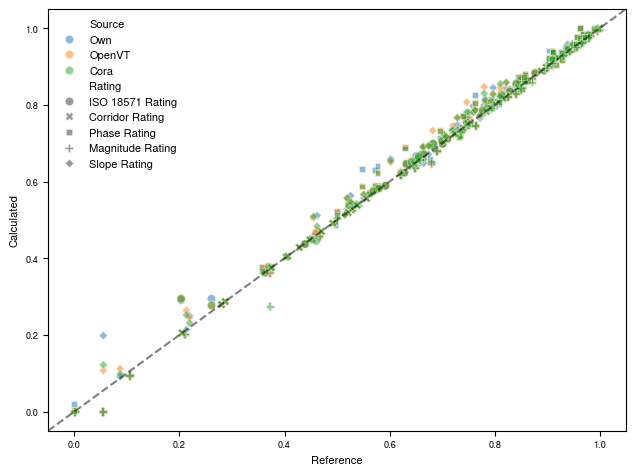

In [13]:
fig, ax = plt.subplots()
sns.scatterplot(data=DELTAS_LONG, x="Reference", y="Calculated", hue="Source", style="Rating", alpha=0.5, ax=ax)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", alpha=0.5, c="black");

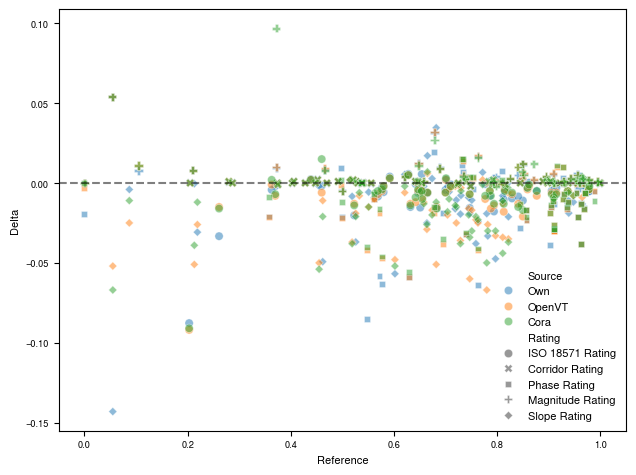

In [14]:
fig, ax = plt.subplots()
sns.scatterplot(data=DELTAS_LONG, x="Reference", y="Delta", hue="Source", style="Rating", alpha=0.5, ax=ax)
ax.axhline(0, ls="--", alpha=0.5, c="black");

In [15]:
px.scatter(DELTAS_LONG, x="Reference", y="Calculated", color="Source", symbol="Rating", hover_data="Info")

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
def cors(metric) -> pd.DataFrame:
    cors = defaultdict(list)
    for rating in DELTAS_LONG["Rating"].unique():
        # data
        own = DELTAS_LONG[DELTAS_LONG["Rating"].eq(rating) & DELTAS_LONG["Source"].eq("Own")]["Calculated"]
        openvt = DELTAS_LONG[DELTAS_LONG["Rating"].eq(rating) & DELTAS_LONG["Source"].eq("OpenVT")]["Calculated"]
        cora = DELTAS_LONG[DELTAS_LONG["Rating"].eq(rating) & DELTAS_LONG["Source"].eq("Cora")]["Calculated"]
        refs =DELTAS_LONG[DELTAS_LONG["Rating"].eq(rating) & DELTAS_LONG["Source"].eq("Own")]["Reference"] 

        # correlations
        cor_own = metric(refs, own)
        cor_openvt = metric(refs, openvt)
        cor_cora = metric(refs, cora)

        # store
        cors["Rating"].append(rating)
        cors["Own"].append(cor_own)
        cors["OpenVT"].append(cor_openvt)
        cors["Cora"].append(cor_cora)
        
    return pd.DataFrame(cors)

CORRELATIONS:Dict[str, pd.DataFrame] = {}
for m_name, m in (("R2", r2_score), ("MAE", mean_absolute_error), ("RSME", root_mean_squared_error)):
    print(m_name)
    CORRELATIONS[m_name] = cors(m)
    display(CORRELATIONS[m_name])

R2


Rating       Own    OpenVT      Cora
0  ISO 18571 Rating  0.991981  0.991882  0.992203
1   Corridor Rating  0.999987  0.999987  0.999984
2      Phase Rating  0.979790  0.987129  0.988379
3  Magnitude Rating  0.998218  0.998167  0.995027
4      Slope Rating  0.978269  0.981034  0.983615

MAE


Rating       Own    OpenVT      Cora
0  ISO 18571 Rating  0.009168  0.009500  0.009214
1   Corridor Rating  0.000561  0.000429  0.000524
2      Phase Rating  0.021212  0.018595  0.017619
3  Magnitude Rating  0.005872  0.005857  0.008095
4      Slope Rating  0.018867  0.022667  0.021095

RSME


Rating       Own    OpenVT      Cora
0  ISO 18571 Rating  0.016607  0.016710  0.016376
1   Corridor Rating  0.000770  0.000756  0.000845
2      Phase Rating  0.028790  0.022976  0.021832
3  Magnitude Rating  0.011080  0.011238  0.018510
4      Slope Rating  0.030601  0.028589  0.026572

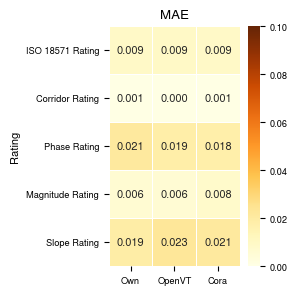

In [17]:
c = CORRELATIONS["MAE"].copy()
c.set_index("Rating", inplace=True)
fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(c, annot=True, fmt=".3f", linewidth=.5,cmap="YlOrBr", vmin=0, vmax=0.1, ax=ax)
ax.set_title("MAE");

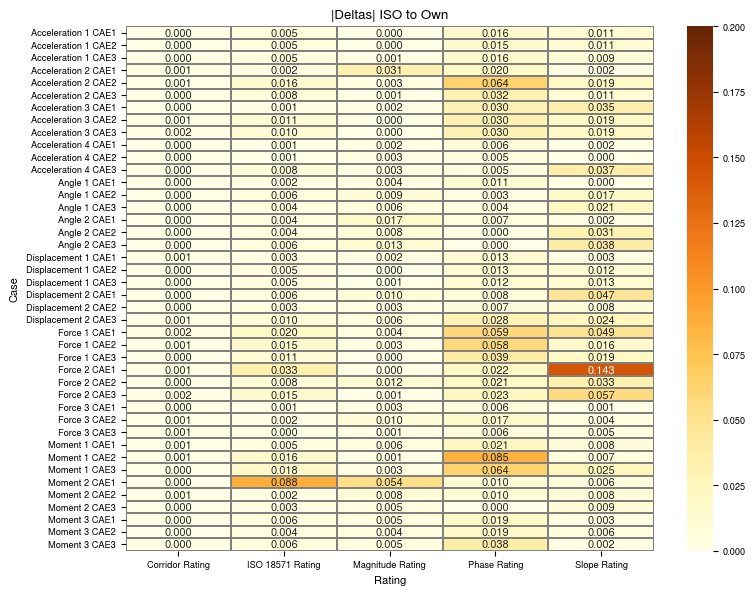

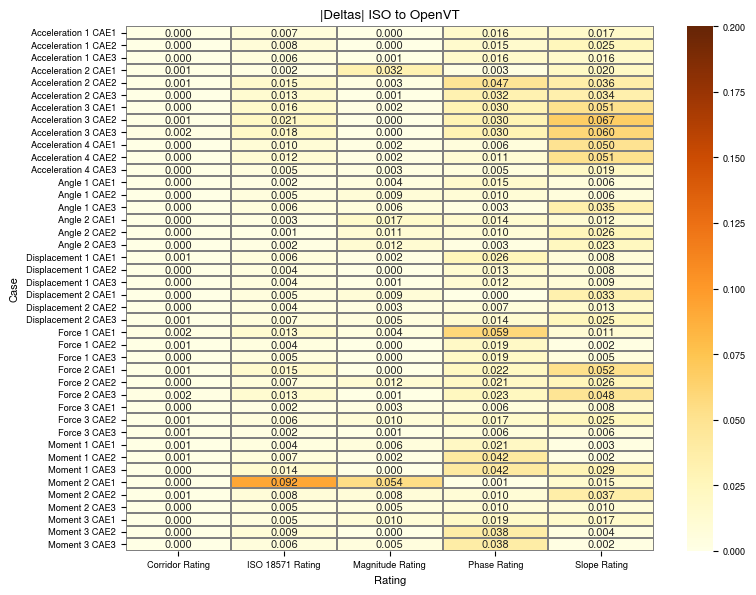

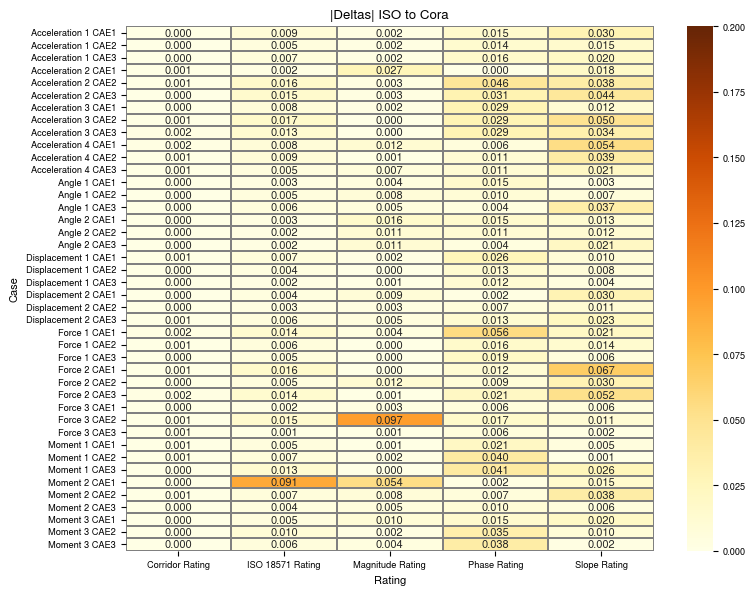

In [18]:
def plot_results(source: str):
    # data
    db = DELTAS_LONG[DELTAS_LONG["Source"].eq(source)].copy()
    db["Delta"] = (db["Reference"] - db["Calculated"]).abs()
    db["Case"] = [" ".join(x.split()[:3]) for x in db["Info"]]
    db = db[["Delta", "Case", "Rating"]].copy()
    db = db.pivot(columns="Rating", index="Case", values="Delta")

    # plot
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(db, annot=True, fmt=".3f", linewidth=0.05, cmap="YlOrBr", ax=ax, vmin=0, vmax=0.2, linecolor="gray")
    ax.set_title(f"|Deltas| ISO to {source}")


for s in DELTAS_LONG["Source"].unique():
    plot_results(s)